## Imports and Setup

In [24]:
"""
Premier League Match Outcome Prediction
A comprehensive machine learning pipeline for predicting match outcomes
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Load Data

In [25]:
filepath = 'premier_league_data.csv'  
df = pd.read_csv(filepath)

print(f"\nDataset Shape: {df.shape}")
print(f"Total Matches: {len(df):,}")
print(f"\nColumn Names and Types (Before Conversion):")
print(df.dtypes)

print("\nConverting score columns to numeric...")
df['Home_team_score'] = pd.to_numeric(df['Home_team_score'], errors='coerce')
df['Away_team_score'] = pd.to_numeric(df['Away_team_score'], errors='coerce')

original_len = len(df)
df = df.dropna(subset=['Home_team_score', 'Away_team_score'])
removed = original_len - len(df)
if removed > 0:
    print(f"Removed {removed} rows with invalid scores")

print(f"\nColumn Names and Types (After Conversion):")
print(df.dtypes)

print(f"\nMissing Values:")
print(df.isnull().sum())

print(f"\nFirst Few Rows:")
print(df.head(10))

print(f"\nBasic Statistics:")
print(df.describe())


Dataset Shape: (33230, 9)
Total Matches: 33,230

Column Names and Types (Before Conversion):
Home_team_score    object
Home_team_name     object
Away_team_score    object
Away_team_name     object
attendance         object
referee            object
stadium            object
Season             object
Date               object
dtype: object

Converting score columns to numeric...
Removed 3 rows with invalid scores

Column Names and Types (After Conversion):
Home_team_score    float64
Home_team_name      object
Away_team_score    float64
Away_team_name      object
attendance          object
referee             object
stadium             object
Season              object
Date                object
dtype: object

Missing Values:
Home_team_score        0
Home_team_name         0
Away_team_score        0
Away_team_name         0
attendance         23291
referee            17946
stadium                0
Season                 0
Date                   0
dtype: int64

First Few Rows:
   Home_te

## Create Match Outcome Target Variable


In [26]:
df['Match_Outcome'] = df.apply(lambda row: 
    'Home_Win' if row['Home_team_score'] > row['Away_team_score']
    else ('Away_Win' if row['Home_team_score'] < row['Away_team_score']
    else 'Draw'), axis=1)

print("Match Outcome Distribution:")
print(df['Match_Outcome'].value_counts())
print("\nPercentages:")
print(df['Match_Outcome'].value_counts(normalize=True) * 100)

Match Outcome Distribution:
Match_Outcome
Home_Win    14675
Away_Win    11015
Draw         7537
Name: count, dtype: int64

Percentages:
Match_Outcome
Home_Win    44.165889
Away_Win    33.150751
Draw        22.683360
Name: proportion, dtype: float64


## Data Vizualization - part 1

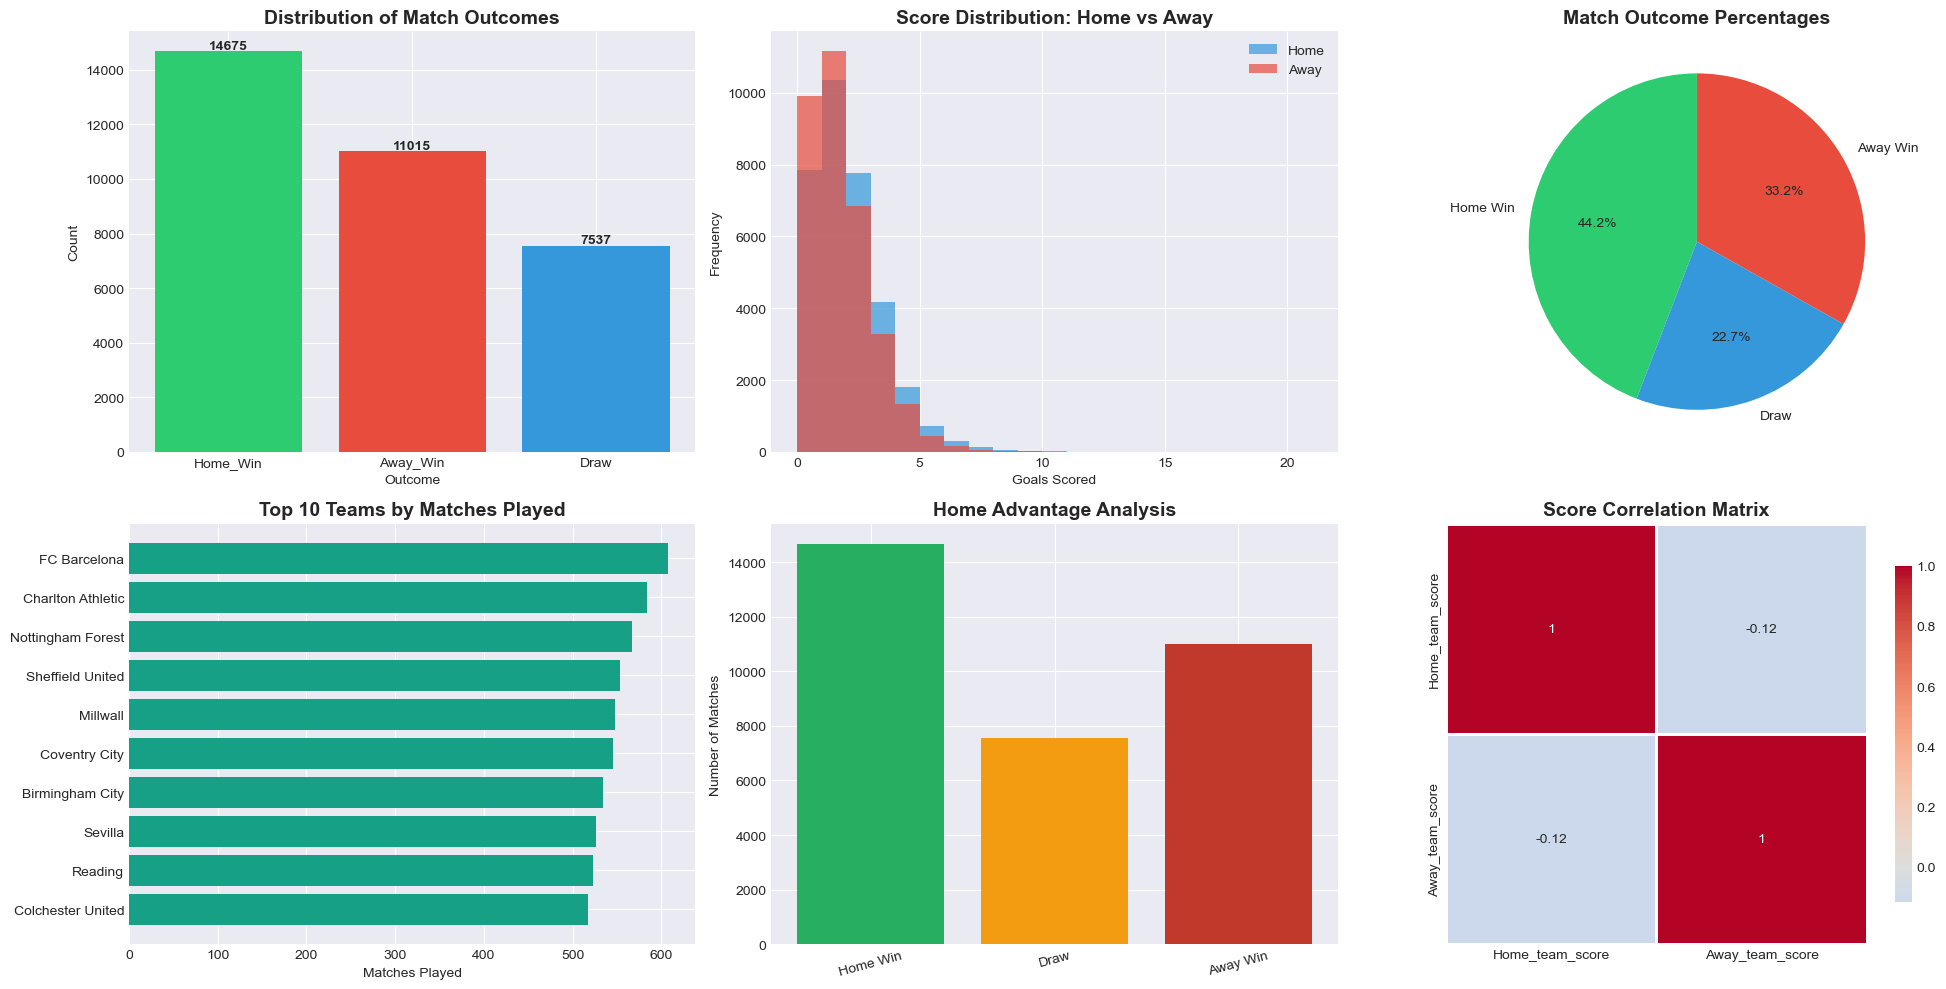

In [27]:
fig = plt.figure(figsize=(20, 10))

# 1. Match Outcomes Distribution
plt.subplot(2, 3, 1)
outcome_counts = df['Match_Outcome'].value_counts()
plt.bar(outcome_counts.index, outcome_counts.values, color=['#2ecc71', '#e74c3c', '#3498db'])
plt.title('Distribution of Match Outcomes', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Outcome')
for i, v in enumerate(outcome_counts.values):
    plt.text(i, v + 100, str(v), ha='center', fontweight='bold')

# 2. Score Distribution
plt.subplot(2, 3, 2)
plt.hist(df['Home_team_score'], bins=range(0, int(df['Home_team_score'].max())+2), 
         alpha=0.7, label='Home', color='#3498db')
plt.hist(df['Away_team_score'], bins=range(0, int(df['Away_team_score'].max())+2), 
         alpha=0.7, label='Away', color='#e74c3c')
plt.title('Score Distribution: Home vs Away', fontsize=14, fontweight='bold')
plt.xlabel('Goals Scored')
plt.ylabel('Frequency')
plt.legend()

# 3. Home vs Away Win Percentage
plt.subplot(2, 3, 3)
win_pct = [
    (outcome_counts['Home_Win'] / len(df)) * 100,
    (outcome_counts['Draw'] / len(df)) * 100,
    (outcome_counts['Away_Win'] / len(df)) * 100
]
plt.pie(win_pct, labels=['Home Win', 'Draw', 'Away Win'], 
        autopct='%1.1f%%', startangle=90, colors=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('Match Outcome Percentages', fontsize=14, fontweight='bold')

# 4. Top 10 Teams by Matches Played
plt.subplot(2, 3, 4)
all_teams = pd.concat([df['Home_team_name'], df['Away_team_name']])
top_teams = all_teams.value_counts().head(10)
plt.barh(range(len(top_teams)), top_teams.values, color='#16a085')
plt.yticks(range(len(top_teams)), top_teams.index)
plt.xlabel('Matches Played')
plt.title('Top 10 Teams by Matches Played', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# 5. Home Advantage Analysis
plt.subplot(2, 3, 5)
home_stats = df.groupby('Match_Outcome').size()
home_adv_data = {
    'Home Win': home_stats.get('Home_Win', 0),
    'Draw': home_stats.get('Draw', 0),
    'Away Win': home_stats.get('Away_Win', 0)
}
plt.bar(home_adv_data.keys(), home_adv_data.values(), 
        color=['#27ae60', '#f39c12', '#c0392b'])
plt.title('Home Advantage Analysis', fontsize=14, fontweight='bold')
plt.ylabel('Number of Matches')
plt.xticks(rotation=15)

# 6. Goals Correlation Heatmap
plt.subplot(2, 3, 6)
corr_data = df[['Home_team_score', 'Away_team_score']].corr()
sns.heatmap(corr_data, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Score Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('data_visualization_part1.png', dpi=300, bbox_inches='tight')
plt.show()

## Data Vizualization - Part 2 (Seasons and Referees)

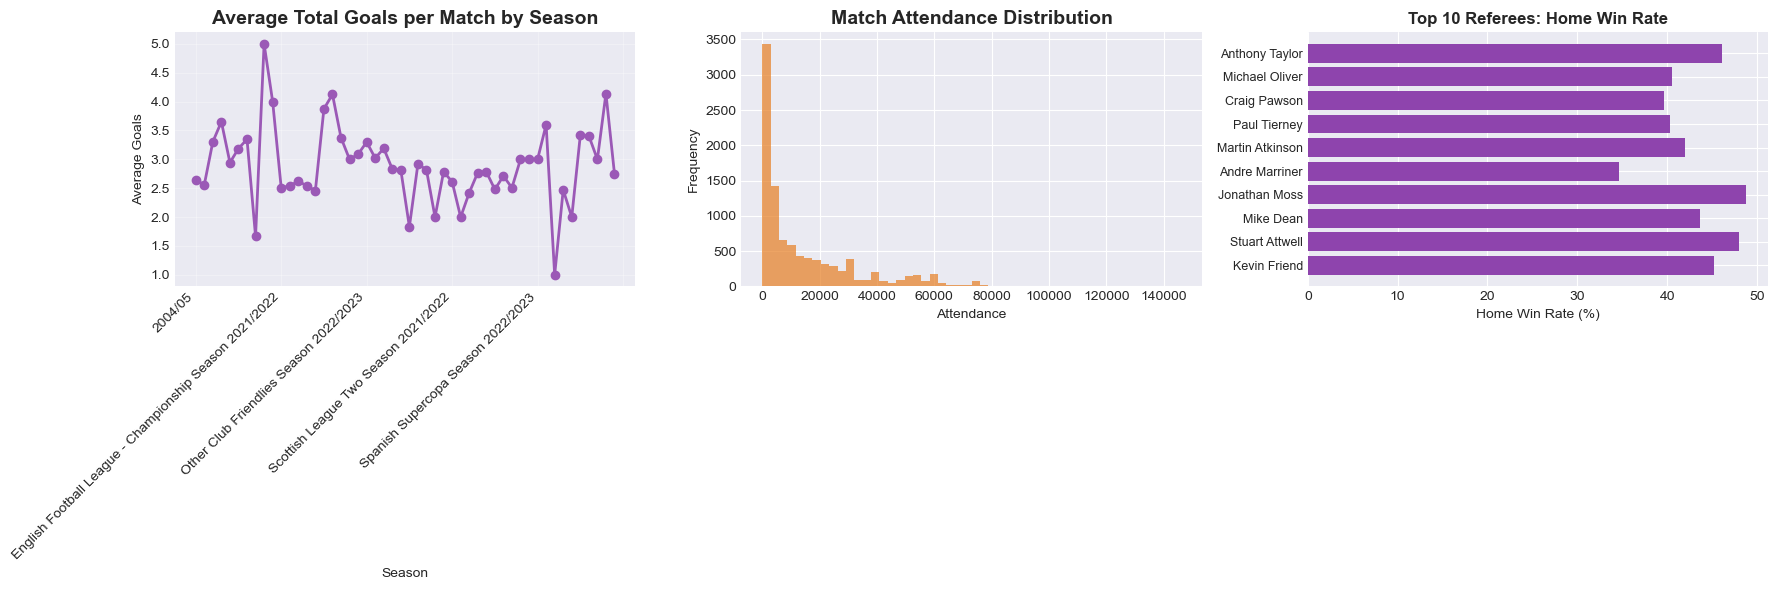

In [28]:
fig = plt.figure(figsize=(18, 6))

# 1. Average Goals per Match by Season
plt.subplot(1, 3, 1)
if 'Season' in df.columns:
    try:
        season_goals = df.groupby('Season')[['Home_team_score', 'Away_team_score']].mean()
        season_goals['Total'] = season_goals['Home_team_score'] + season_goals['Away_team_score']
        season_goals = season_goals.sort_index()
        
        if len(season_goals) > 20:
            season_goals = season_goals.iloc[::3]
        
        season_goals['Total'].plot(kind='line', marker='o', color='#9b59b6', linewidth=2)
        plt.title('Average Total Goals per Match by Season', fontsize=14, fontweight='bold')
        plt.xlabel('Season')
        plt.ylabel('Average Goals')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        plt.text(0.5, 0.5, 'Season data processing error', ha='center', va='center')

# 2. Attendance Distribution
plt.subplot(1, 3, 2)
if 'attendance' in df.columns:
    attendance_str = df['attendance'].astype(str).str.replace(',', '').str.replace('Att: ', '').str.strip()
    attendance_numeric = pd.to_numeric(attendance_str, errors='coerce')
    attendance_clean = attendance_numeric.dropna()
    
    if len(attendance_clean) > 0:
        plt.hist(attendance_clean, bins=50, color='#e67e22', alpha=0.7)
        plt.title('Match Attendance Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Attendance')
        plt.ylabel('Frequency')
    else:
        plt.text(0.5, 0.5, 'Attendance data unavailable', ha='center', va='center')

# 3. Win Rate by Top Referees
plt.subplot(1, 3, 3)
if 'referee' in df.columns:
    try:
        ref_stats = df.groupby('referee')['Match_Outcome'].value_counts().unstack(fill_value=0)
        if len(ref_stats) > 0:
            top_refs = ref_stats.sum(axis=1).nlargest(10).index
            ref_home_win_rate = (ref_stats.loc[top_refs, 'Home_Win'] / 
                                ref_stats.loc[top_refs].sum(axis=1) * 100)
            plt.barh(range(len(ref_home_win_rate)), ref_home_win_rate.values, color='#8e44ad')
            plt.yticks(range(len(ref_home_win_rate)), top_refs, fontsize=9)
            plt.xlabel('Home Win Rate (%)')
            plt.title('Top 10 Referees: Home Win Rate', fontsize=12, fontweight='bold')
            plt.gca().invert_yaxis()
    except Exception as e:
        plt.text(0.5, 0.5, 'Referee data unavailable', ha='center', va='center')

plt.tight_layout()
plt.savefig('data_visualization_part2.png', dpi=300, bbox_inches='tight')
plt.show()

## Feature Engineering

In [29]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.sort_values('Date').reset_index(drop=True)
    print("Data sorted by date")

print("\nCalculating home team statistics...")
home_team_stats = df.groupby('Home_team_name')['Home_team_score'].expanding().mean()
df['home_avg_goals'] = home_team_stats.reset_index(level=0, drop=True).shift(1).fillna(1.5)

print("Calculating away team statistics...")
away_team_stats = df.groupby('Away_team_name')['Away_team_score'].expanding().mean()
df['away_avg_goals'] = away_team_stats.reset_index(level=0, drop=True).shift(1).fillna(1.2)

print("Calculating home team win rate...")
df['home_is_win'] = (df['Home_team_score'] > df['Away_team_score']).astype(int)
home_win_rate = df.groupby('Home_team_name')['home_is_win'].expanding().mean()
df['home_win_rate'] = home_win_rate.reset_index(level=0, drop=True).shift(1).fillna(0.45)

print("Calculating away team win rate...")
df['away_is_win'] = (df['Away_team_score'] > df['Home_team_score']).astype(int)
away_win_rate = df.groupby('Away_team_name')['away_is_win'].expanding().mean()
df['away_win_rate'] = away_win_rate.reset_index(level=0, drop=True).shift(1).fillna(0.30)

df['goal_difference'] = df['Home_team_score'] - df['Away_team_score']
df['total_goals'] = df['Home_team_score'] + df['Away_team_score']
df['high_scoring'] = (df['total_goals'] > 3).astype(int)

print(f"\nFeature engineering complete!")
print(f"Total columns now: {len(df.columns)}")
print(f"Key features created: home_avg_goals, away_avg_goals, home_win_rate, away_win_rate")

Data sorted by date

Calculating home team statistics...
Calculating away team statistics...
Calculating home team win rate...
Calculating away team win rate...

Feature engineering complete!
Total columns now: 19
Key features created: home_avg_goals, away_avg_goals, home_win_rate, away_win_rate


## Data Preprocessing

In [30]:
feature_columns = [
    'Home_team_name', 
    'Away_team_name', 
    'home_avg_goals', 
    'away_avg_goals', 
    'home_win_rate', 
    'away_win_rate'
]

if 'referee' in df.columns:
    non_null_referees = df['referee'].notna().sum()
    if non_null_referees > len(df) * 0.5:
        feature_columns.append('referee')
        print(f"    Including referee feature ({non_null_referees:,} non-null values)")

if 'stadium' in df.columns:
    non_null_stadiums = df['stadium'].notna().sum()
    if non_null_stadiums > len(df) * 0.5:
        feature_columns.append('stadium')
        print(f"    Including stadium feature ({non_null_stadiums:,} non-null values)")

df_clean = df.dropna(subset=feature_columns + ['Match_Outcome'])

print(f"\nSamples before cleaning: {len(df):,}")
print(f"Samples after cleaning: {len(df_clean):,}")

X = df_clean[feature_columns].copy()
y = df_clean['Match_Outcome'].copy()

print(f"\nSelected features: {feature_columns}")
print(f"\nTarget distribution:")
print(y.value_counts())

print("\n" + "="*50)
print("Encoding categorical variables...")
print("="*50)
label_encoders = {}

for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"    Encoded {col}: {len(le.classes_):,} unique values")

print("\nScaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"\nPreprocessing complete!")
print(f"Final feature matrix shape: {X_scaled.shape}")
print(f"Features: {list(X_scaled.columns)}")

    Including stadium feature (33,227 non-null values)

Samples before cleaning: 33,227
Samples after cleaning: 33,227

Selected features: ['Home_team_name', 'Away_team_name', 'home_avg_goals', 'away_avg_goals', 'home_win_rate', 'away_win_rate', 'stadium']

Target distribution:
Match_Outcome
Home_Win    14675
Away_Win    11015
Draw         7537
Name: count, dtype: int64

Encoding categorical variables...
    Encoded Home_team_name: 1,282 unique values
    Encoded Away_team_name: 1,298 unique values
    Encoded stadium: 1,591 unique values

Scaling features...

Preprocessing complete!
Final feature matrix shape: (33227, 7)
Features: ['Home_team_name', 'Away_team_name', 'home_avg_goals', 'away_avg_goals', 'home_win_rate', 'away_win_rate', 'stadium']


## Train-Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {len(X_train):,} samples ({len(X_train)/len(X_scaled)*100:.1f}%)")
print(f"Testing set size:  {len(X_test):,} samples ({len(X_test)/len(X_scaled)*100:.1f}%)")

print(f"\nTraining set target distribution:")
print(y_train.value_counts())
print(f"\nTesting set target distribution:")
print(y_test.value_counts())


Training set size: 26,581 samples (80.0%)
Testing set size:  6,646 samples (20.0%)

Training set target distribution:
Match_Outcome
Home_Win    11740
Away_Win     8812
Draw         6029
Name: count, dtype: int64

Testing set target distribution:
Match_Outcome
Home_Win    2935
Away_Win    2203
Draw        1508
Name: count, dtype: int64


## Algorithm 1 - Random Forest Classifier

In [32]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Testing combinations of:")
for param, values in param_grid_rf.items():
    print(f"  - {param}: {values}")

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(
    rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

print("\nTraining Random Forest with 5-fold cross-validation...")
grid_search_rf.fit(X_train, y_train)

print(f"\n Best parameters found: {grid_search_rf.best_params_}")
print(f" Best cross-validation score: {grid_search_rf.best_score_:.4f}")

best_rf = grid_search_rf.best_estimator_

y_pred_train_rf = best_rf.predict(X_train)
y_pred_test_rf = best_rf.predict(X_test)

train_acc_rf = accuracy_score(y_train, y_pred_train_rf)
test_acc_rf = accuracy_score(y_test, y_pred_test_rf)
f1_rf = f1_score(y_test, y_pred_test_rf, average='weighted')

print("\n" + "="*80)
print("RESULTS")
print("="*80)
print(f"Training Accuracy:   {train_acc_rf:.4f} ({train_acc_rf*100:.2f}%)")
print(f"Testing Accuracy:    {test_acc_rf:.4f} ({test_acc_rf*100:.2f}%)")
print(f"F1-Score (Weighted): {f1_rf:.4f}")

print("\n" + "="*80)
print("CLASSIFICATION REPORT (Test Set)")
print("="*80)
print(classification_report(y_test, y_pred_test_rf))

feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)
print(feature_importance_rf)

Testing combinations of:
  - n_estimators: [100, 200]
  - max_depth: [10, 20, None]
  - min_samples_split: [2, 5]
  - min_samples_leaf: [1, 2]

Training Random Forest with 5-fold cross-validation...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

 Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
 Best cross-validation score: 0.4743

RESULTS
Training Accuracy:   0.5464 (54.64%)
Testing Accuracy:    0.4723 (47.23%)
F1-Score (Weighted): 0.3914

CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

    Away_Win       0.46      0.31      0.37      2203
        Draw       0.00      0.00      0.00      1508
    Home_Win       0.48      0.83      0.61      2935

    accuracy                           0.47      6646
   macro avg       0.31      0.38      0.33      6646
weighted avg       0.36      0.47      0.39      6646


FEATURE IMPORTANCE
          feature  importance
4   home_win_ra

## Algorithm 2 - Gradient Boosting Classifier

In [33]:
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

print("Testing combinations of:")
for param, values in param_grid_gb.items():
    print(f"  - {param}: {values}")

gb = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(
    gb, param_grid_gb, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

print("\nTraining Gradient Boosting with 5-fold cross-validation...")
grid_search_gb.fit(X_train, y_train)

print(f"\n Best parameters found: {grid_search_gb.best_params_}")
print(f" Best cross-validation score: {grid_search_gb.best_score_:.4f}")

best_gb = grid_search_gb.best_estimator_

y_pred_train_gb = best_gb.predict(X_train)
y_pred_test_gb = best_gb.predict(X_test)

train_acc_gb = accuracy_score(y_train, y_pred_train_gb)
test_acc_gb = accuracy_score(y_test, y_pred_test_gb)
f1_gb = f1_score(y_test, y_pred_test_gb, average='weighted')

print("\n" + "="*80)
print("RESULTS")
print("="*80)
print(f"Training Accuracy:   {train_acc_gb:.4f} ({train_acc_gb*100:.2f}%)")
print(f"Testing Accuracy:    {test_acc_gb:.4f} ({test_acc_gb*100:.2f}%)")
print(f"F1-Score (Weighted): {f1_gb:.4f}")

print("\n" + "="*80)
print("CLASSIFICATION REPORT (Test Set)")
print("="*80)
print(classification_report(y_test, y_pred_test_gb))

feature_importance_gb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_gb.feature_importances_
}).sort_values('importance', ascending=False)

print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)
print(feature_importance_gb)

Testing combinations of:
  - n_estimators: [100, 200]
  - learning_rate: [0.05, 0.1]
  - max_depth: [3, 5]
  - min_samples_split: [2, 5]

Training Gradient Boosting with 5-fold cross-validation...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

 Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200}
 Best cross-validation score: 0.4751

RESULTS
Training Accuracy:   0.5075 (50.75%)
Testing Accuracy:    0.4782 (47.82%)
F1-Score (Weighted): 0.4027

CLASSIFICATION REPORT (Test Set)
              precision    recall  f1-score   support

    Away_Win       0.47      0.35      0.40      2203
        Draw       0.31      0.01      0.01      1508
    Home_Win       0.48      0.82      0.61      2935

    accuracy                           0.48      6646
   macro avg       0.42      0.39      0.34      6646
weighted avg       0.44      0.48      0.40      6646


FEATURE IMPORTANCE
          feature  importance
3  away_avg_goals   

## Model Comparison

In [36]:
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'Training Accuracy': [train_acc_rf, train_acc_gb],
    'Testing Accuracy': [test_acc_rf, test_acc_gb],
    'F1-Score': [f1_rf, f1_gb]
})

print("\n" + "="*80)
print("PERFORMANCE METRICS COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

best_model_name = comparison_df.loc[comparison_df['Testing Accuracy'].idxmax(), 'Model']
best_accuracy = comparison_df['Testing Accuracy'].max()

print(f"\nBEST MODEL: {best_model_name}")
print(f"   Testing Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")


PERFORMANCE METRICS COMPARISON
            Model  Training Accuracy  Testing Accuracy  F1-Score
    Random Forest           0.546368          0.472314  0.391370
Gradient Boosting           0.507543          0.478182  0.402716

BEST MODEL: Gradient Boosting
   Testing Accuracy: 0.4782 (47.82%)


## Visualization - Model Comparison

✓ Model comparison visualization saved as 'model_comparison.png'


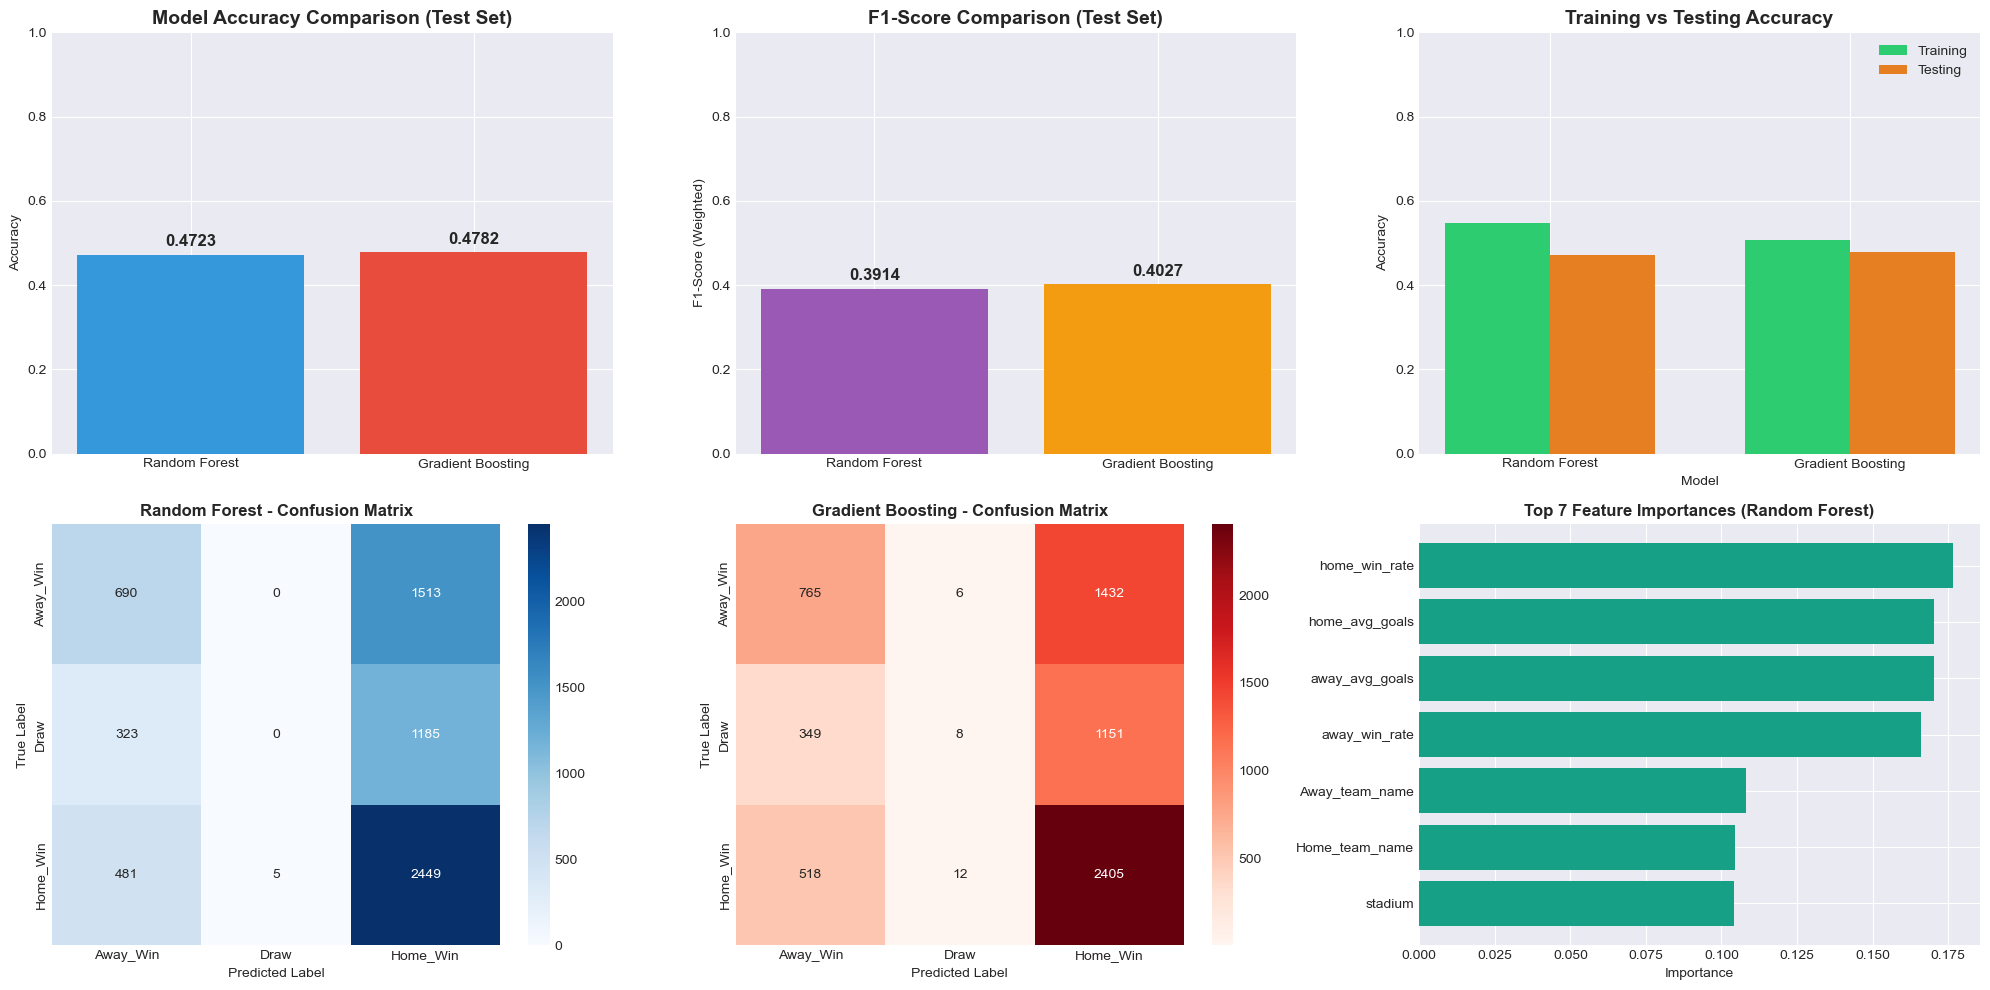

In [35]:
fig = plt.figure(figsize=(20, 10))

# 1. Accuracy Comparison
plt.subplot(2, 3, 1)
models = ['Random Forest', 'Gradient Boosting']
test_accuracies = [test_acc_rf, test_acc_gb]
bars = plt.bar(models, test_accuracies, color=['#3498db', '#e74c3c'])
plt.title('Model Accuracy Comparison (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
for i, (bar, acc) in enumerate(zip(bars, test_accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 0.02, 
            f'{acc:.4f}', ha='center', fontweight='bold', fontsize=12)

# 2. F1-Score Comparison
plt.subplot(2, 3, 2)
f1_scores = [f1_rf, f1_gb]
bars = plt.bar(models, f1_scores, color=['#9b59b6', '#f39c12'])
plt.title('F1-Score Comparison (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('F1-Score (Weighted)')
plt.ylim([0, 1])
for i, (bar, f1) in enumerate(zip(bars, f1_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, f1 + 0.02, 
            f'{f1:.4f}', ha='center', fontweight='bold', fontsize=12)

# 3. Training vs Testing Accuracy
plt.subplot(2, 3, 3)
x = np.arange(len(models))
width = 0.35
bars1 = plt.bar(x - width/2, [train_acc_rf, train_acc_gb], width, label='Training', color='#2ecc71')
bars2 = plt.bar(x + width/2, [test_acc_rf, test_acc_gb], width, label='Testing', color='#e67e22')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy', fontsize=14, fontweight='bold')
plt.xticks(x, models)
plt.legend()
plt.ylim([0, 1])

# 4. Confusion Matrix - Random Forest
plt.subplot(2, 3, 4)
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
           xticklabels=['Away_Win', 'Draw', 'Home_Win'],
           yticklabels=['Away_Win', 'Draw', 'Home_Win'])
plt.title('Random Forest - Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 5. Confusion Matrix - Gradient Boosting
plt.subplot(2, 3, 5)
cm_gb = confusion_matrix(y_test, y_pred_test_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Reds', 
           xticklabels=['Away_Win', 'Draw', 'Home_Win'],
           yticklabels=['Away_Win', 'Draw', 'Home_Win'])
plt.title('Gradient Boosting - Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 6. Feature Importance Comparison
plt.subplot(2, 3, 6)
top_n = min(8, len(feature_importance_rf))
top_features_rf = feature_importance_rf.head(top_n)
plt.barh(range(len(top_features_rf)), top_features_rf['importance'].values, color='#16a085')
plt.yticks(range(len(top_features_rf)), top_features_rf['feature'].values)
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances (Random Forest)', fontsize=12, fontweight='bold')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Model comparison visualization saved as 'model_comparison.png'")
plt.show()